Peter Henry 

Digit Recognizer

Lets predict some handwritten numbers using Kaggles Digit Recognizer dataset

https://www.kaggle.com/c/digit-recognizer/data

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics import confusion_matrix

In [10]:
# gpu check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


Loading Dataset

In [11]:
train_data = pd.read_csv(r"C:\Users\peter\OneDrive\Documents\Portfolio - Data Science\Extracurricular\Coding\Digit Recognizer\input\train.csv")
test_data = pd.read_csv(r"C:\Users\peter\OneDrive\Documents\Portfolio - Data Science\Extracurricular\Coding\Digit Recognizer\input\test.csv")

In [12]:
# Feauture Separation
X_train = train_data.iloc[:,1:].values.astype('float32')
y_train = train_data.iloc[:,0].values.astype('int64')

X_test = test_data.values.astype('float32')

Visual of Digit Distribution

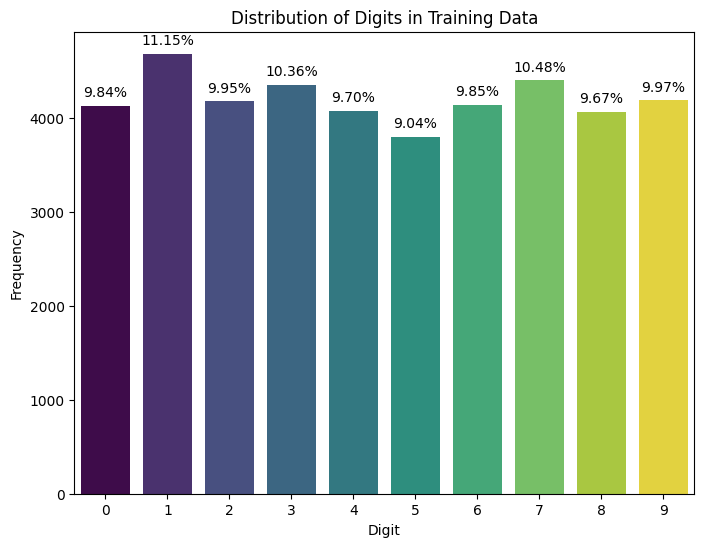

In [13]:
label_counts = pd.Series(y_train).value_counts().sort_index()
total_count = label_counts.sum()
percentages = (label_counts / total_count) * 100

plt.figure(figsize=(8, 6))
bar_plot = sns.barplot(x=label_counts.index, y=label_counts.values, hue=label_counts.index, palette='viridis', legend=False)

for i, percentage in enumerate(percentages):
    bar_plot.text(i, label_counts[i] + 100, f'{percentage:.2f}%', ha='center')


plt.title('Distribution of Digits in Training Data')
plt.xlabel('Digit')
plt.ylabel('Frequency')
plt.show()

Sample Digits in order

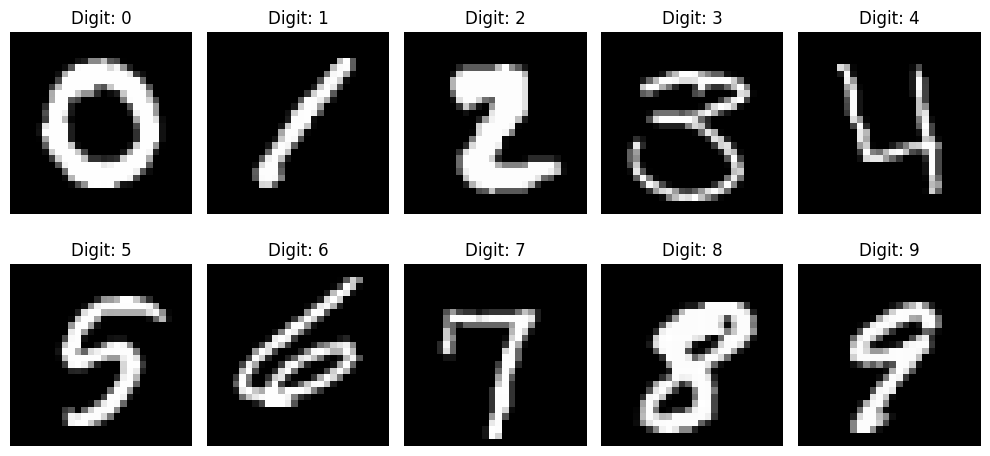

In [14]:
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i in range(10):
    index = np.where(y_train == i)[0][0]
    ax = axes[i // 5, i % 5]
    ax.imshow(X_train[index].reshape(28, 28), cmap='gray')
    ax.set_title(f"Digit: {i}")
    ax.axis('off')
plt.tight_layout()
plt.show()

Distribution of Pixel Density

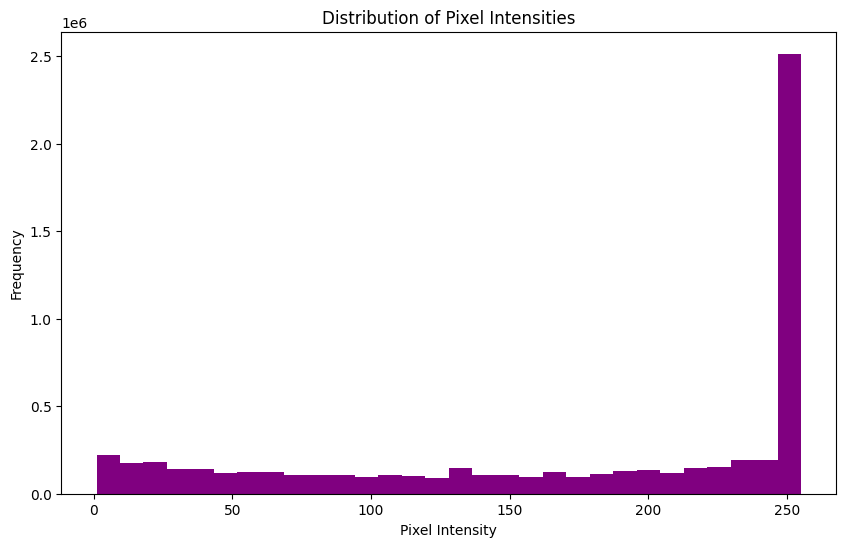

In [15]:
pixel_values = X_train.flatten()
pixel_values_non_zero = pixel_values[pixel_values > 0]

plt.figure(figsize=(10, 6))
plt.hist(pixel_values_non_zero, bins=30, color='purple')
plt.title("Distribution of Pixel Intensities")
plt.xlabel("Pixel Intensity")
plt.ylabel('Frequency')
plt.show()

Average Image for Each Digit (0-9)

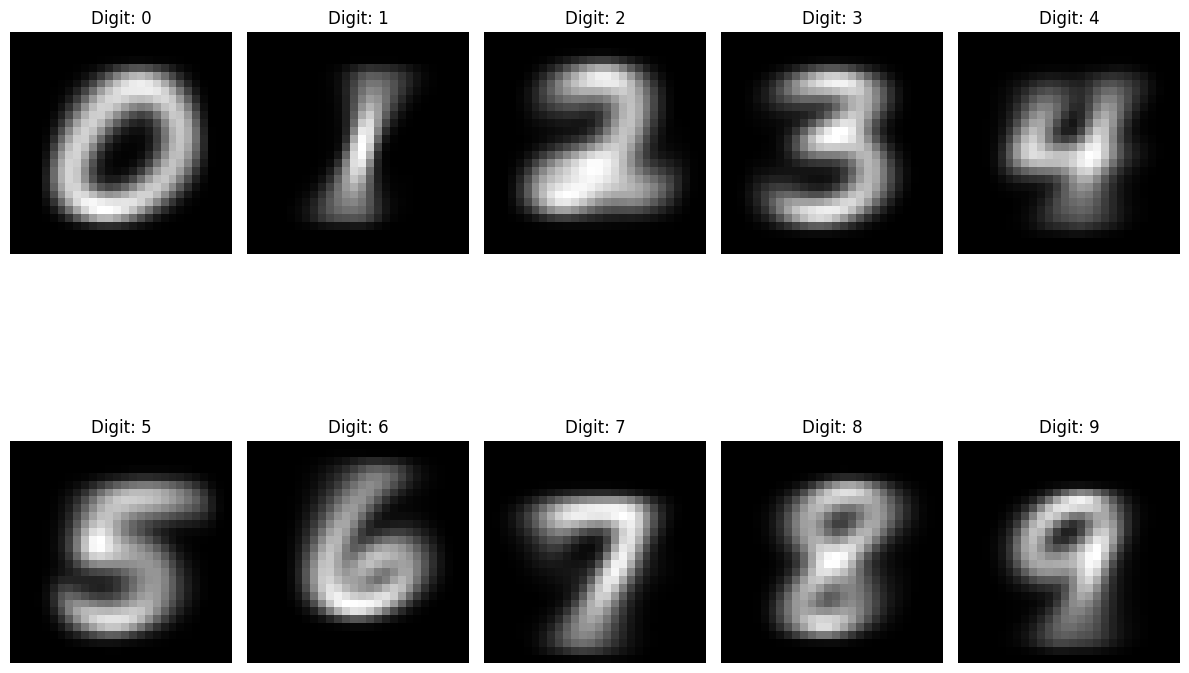

In [16]:
avg_images = np.zeros((10, 28, 28))  # Store the average image for each digit

for digit in range(10):
    digit_images = X_train[y_train == digit]
    digit_images_reshaped = digit_images.reshape(-1, 28, 28)
    avg_images[digit] = np.mean(digit_images_reshaped, axis=0)

plt.figure(figsize=(12, 10))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(avg_images[i], cmap='gray')
    plt.title(f"Digit: {i}")
    plt.axis('off')

plt.tight_layout()
plt.show()

Pixel Variance Across All Images

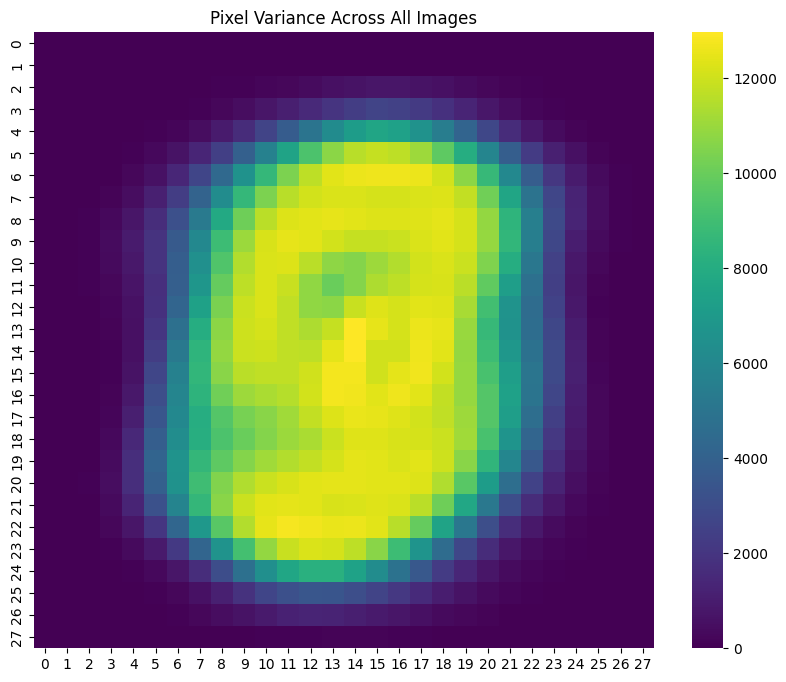

In [17]:
pixel_variances = np.var(X_train, axis=0).reshape(28, 28)

plt.figure(figsize=(10, 8))
sns.heatmap(pixel_variances, cmap='viridis')
plt.title('Pixel Variance Across All Images')
plt.show()

Preprocess Data

In [18]:
# Reshape to 28x28 images
X_train = X_train.reshape(-1,1,28,28)
X_test = X_test.reshape(-1,1,28,28)

# Define the transform pipeline
transform = transforms.Compose([
    transforms.RandomRotation(5),  # Randomly rotate images by up to 10 degrees
    transforms.RandomAffine(0, translate=(0.1, 0.1)),  # Randomly translate by 10% of width and height
    #transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images with a probability of 50% --- worsened accuracy as flipping the image to a a digit can make it backwards.
    #transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Randomly change brightness and contrast -- did not increase or decrease accuracy.
    #transforms.RandomResizedCrop(28, scale=(0.9, 1.1), ratio=(0.95, 1.05)),  # Rescale and crop -- Dramatically reduced accuracy at any ratio and scale.
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize the images to [-1, 1]
])

Dataset Class

In [19]:
class DigitDataset(Dataset):
    def __init__(self, images, labels=None,transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self,idx):
        image = self.images[idx]
        if self.transform:
            image = torch.tensor(image)
        if self.labels is not None:
            label = self.labels[idx]
            return image, label
        else:
            return image
        

# Create dataset instances
train_dataset = DigitDataset(X_train,y_train,transform=transform)   # Apply transforms to training data
test_dataset = DigitDataset(X_test,transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
]))   # No data augmentation for test set

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)

CNN Architecture

In [20]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.fc1 = nn.Linear(256 * 1 * 1, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

        self.dropout = nn.Dropout(0.3) # Droput to prevent overfitting

    def forward(self, x):
        x = nn.functional.relu(self.bn1(nn.functional.max_pool2d(self.conv1(x), 2)))
        x = nn.functional.relu(self.bn2(nn.functional.max_pool2d(self.conv2(x), 2)))
        x = nn.functional.relu(self.bn3(nn.functional.max_pool2d(self.conv3(x), 2)))
        x = nn.functional.relu(self.bn4(nn.functional.max_pool2d(self.conv4(x), 2)))
        x = x.view(-1, 256 * 1 * 1) # Flatten Tensor
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Train Network

In [21]:
# Early stopping parameters
patience = 7
best_val_loss = float('inf')
stagnant_epochs = 0

# Train Network
net = Net().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=patience // 2, verbose=True) 

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
all_preds = []
all_labels = []

# Training Loop
for epoch in range(50):
    net.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calc accuracy
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    # Avg training loss
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Calc accuracy for this epoch
    train_accuracy = 100 * correct / total
    train_accuracies.append(train_accuracy)

    print(f"Epoch {epoch + 1}, Training Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")

    # Validation step
    net.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Store predictions and labels for confusion matrix
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Avg validation loss for the epoch
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    print(f'Epoch {epoch + 1}, Validation Loss: {val_loss:.4f}')

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        stagnant_epochs = 0
    else:
        stagnant_epochs += 1
    
    # Stop if patience has been exceeded
    if stagnant_epochs >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

    scheduler.step(val_loss)

print('Finished Training')


c:\Users\peter\anaconda3\envs\DeepLearning\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1, Training Loss: 0.1493, Accuracy: 95.63%
Epoch 1, Validation Loss: 0.0621
Epoch 2, Training Loss: 0.0483, Accuracy: 98.64%
Epoch 2, Validation Loss: 0.0473
Epoch 3, Training Loss: 0.0374, Accuracy: 98.89%
Epoch 3, Validation Loss: 0.0522
Epoch 4, Training Loss: 0.0339, Accuracy: 99.04%
Epoch 4, Validation Loss: 0.0556
Epoch 5, Training Loss: 0.0265, Accuracy: 99.14%
Epoch 5, Validation Loss: 0.0504
Epoch 6, Training Loss: 0.0218, Accuracy: 99.43%
Epoch 6, Validation Loss: 0.0579
Epoch 7, Training Loss: 0.0095, Accuracy: 99.74%
Epoch 7, Validation Loss: 0.0297
Epoch 8, Training Loss: 0.0050, Accuracy: 99.88%
Epoch 8, Validation Loss: 0.0293
Epoch 9, Training Loss: 0.0031, Accuracy: 99.91%
Epoch 9, Validation Loss: 0.0301
Epoch 10, Training Loss: 0.0029, Accuracy: 99.93%
Epoch 10, Validation Loss: 0.0304
Epoch 11, Training Loss: 0.0022, Accuracy: 99.95%
Epoch 11, Validation Loss: 0.0318
Epoch 12, Training Loss: 0.0014, Accuracy: 99.98%
Epoch 12, Validation Loss: 0.0328
Epoch 13, 

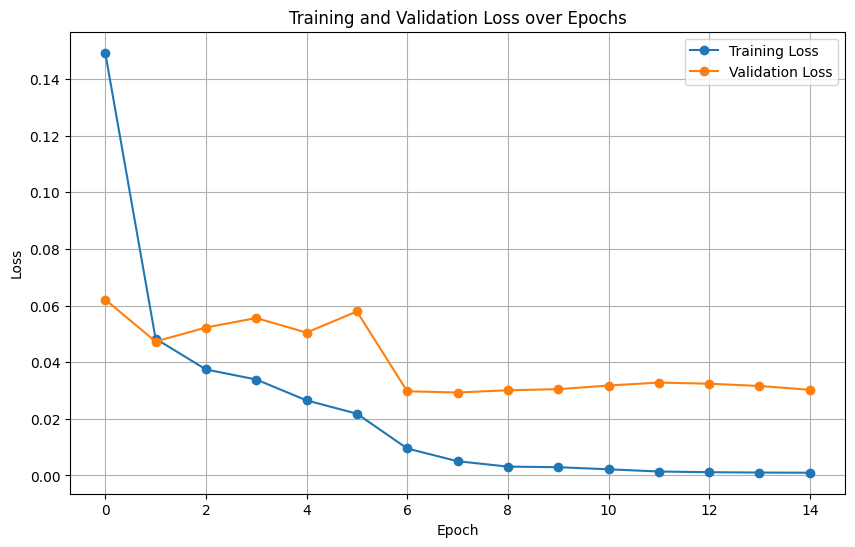

In [22]:
# Plotting the loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

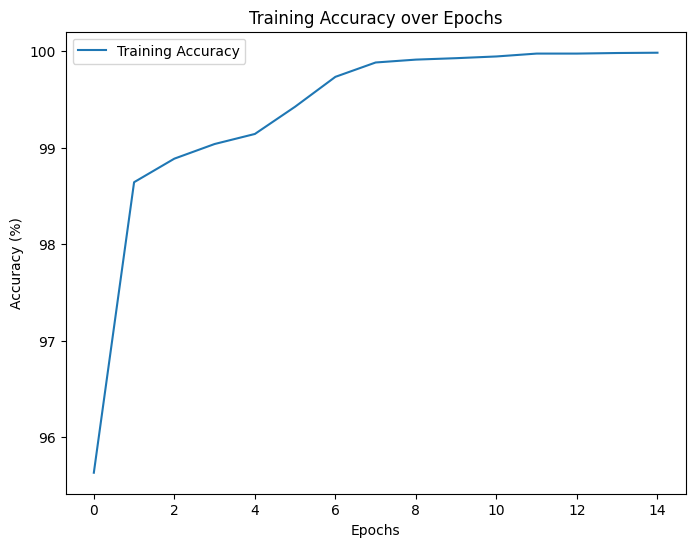

In [23]:
# Training Accuracy over Epochs
plt.figure(figsize=(8, 6))
plt.plot(train_accuracies, label='Training Accuracy')
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

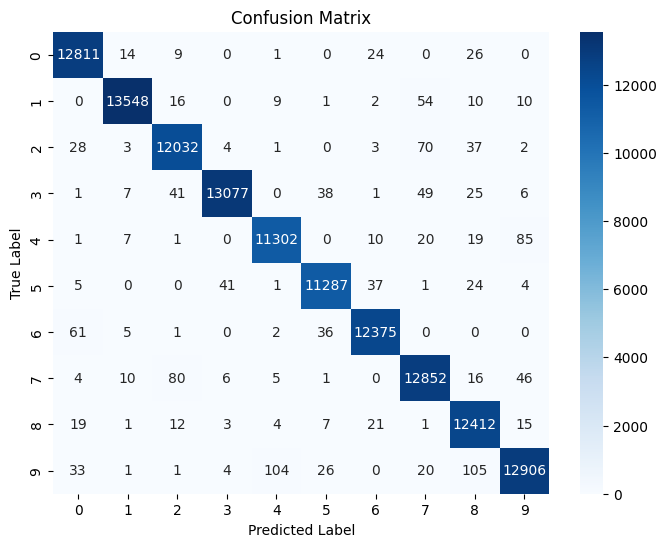

In [24]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(range(10)), yticklabels=list(range(10)))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [28]:
# Accuracy by Digit Class
class_accuracy = cm.diagonal() / cm.sum(axis=1)
for i, acc in enumerate(class_accuracy):
    print(f"Accuracy for digit {i}: {acc * 100:.2f}%")

Accuracy for digit 0: 99.43%
Accuracy for digit 1: 99.25%
Accuracy for digit 2: 98.78%
Accuracy for digit 3: 98.73%
Accuracy for digit 4: 98.75%
Accuracy for digit 5: 99.01%
Accuracy for digit 6: 99.16%
Accuracy for digit 7: 98.71%
Accuracy for digit 8: 99.34%
Accuracy for digit 9: 97.77%


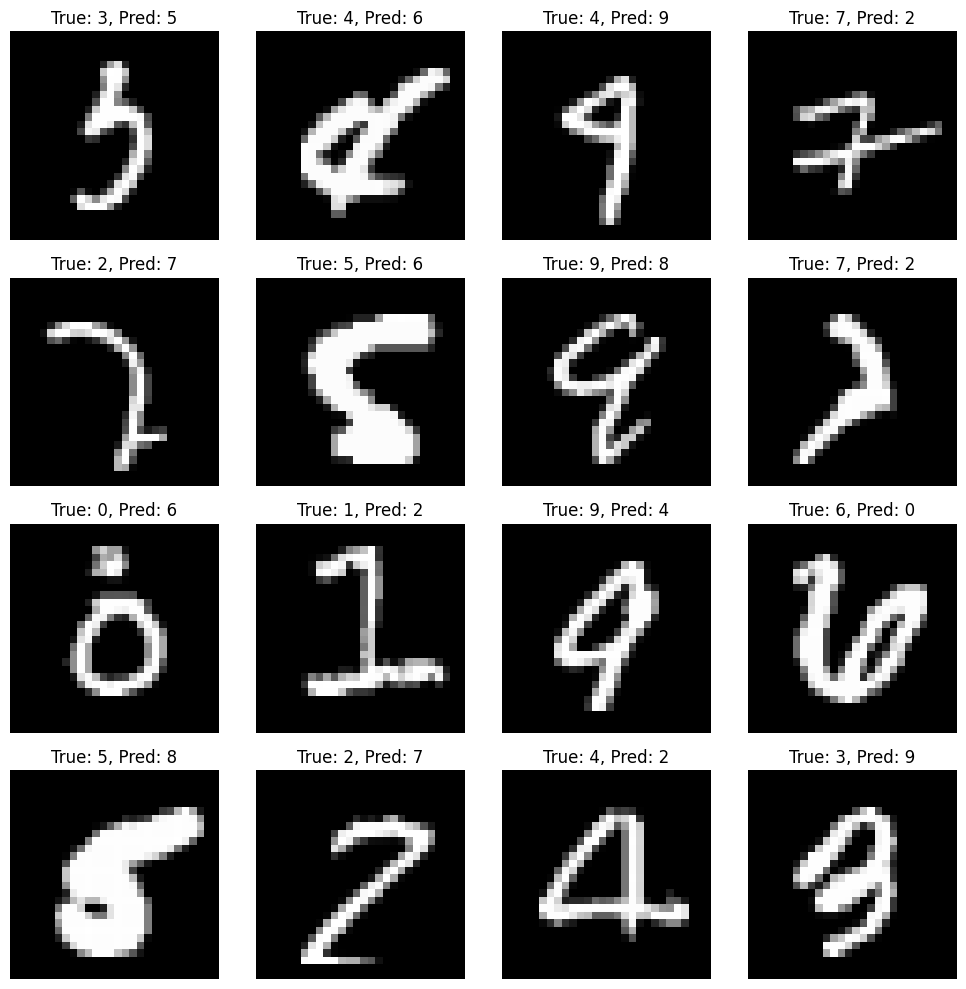

In [31]:
# Misclassified Digit Classes
misclassified_idx = np.where(np.array(all_preds) != np.array(all_labels))[0]
val_images = [image.numpy().squeeze() for image, label in val_loader.dataset]
plt.figure(figsize=(10, 10))
for i, idx in enumerate(misclassified_idx[:16]):
    plt.subplot(4, 4, i + 1)
    img = val_images[idx]
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {all_labels[idx]}, Pred: {all_preds[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

Generation of Predicitions for Kaggle Submission

In [159]:
test_dataset = DigitDataset(X_test, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

results = []
batch_count = 0 
checkpoint_interval = 100  
model_name = 'CNN_Digit_Recognizer'

net.eval()

with torch.no_grad():  # Disable gradient calculation for inference
    for images in test_loader:
        images = images.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        results.extend(predicted.cpu().numpy())
        batch_count += 1
        if batch_count % checkpoint_interval == 0:
            # Save intermediate results to a checkpoint file
            checkpoint_submission = pd.DataFrame({'ImageId': list(range(1, len(results)+1)), 'Label': results})
            checkpoint_submission.to_csv(f'submission_checkpoint_{model_name}.csv', index=False)
            print(f"Checkpoint saved after {batch_count} batches.")
current_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
final_filename = f'submission_{model_name}_{current_time}.csv'
submission = pd.DataFrame({'ImageId': list(range(1, len(results)+1)), 'Label': results})
submission.to_csv(final_filename, index=False)
print(f"Final submission file created: '{final_filename}'")

Checkpoint saved after 100 batches.
Checkpoint saved after 200 batches.
Checkpoint saved after 300 batches.
Checkpoint saved after 400 batches.
Final submission file created: 'submission_CNN_Digit_Recognizer_2024-09-24_15-44-03.csv'
